In [516]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
cd /Users/mehdi/Documents/WorkingFolder/PHd/weight_vector_simulations_paper/weight_vector_estim_code/

/Users/mehdi/Dropbox/working folder/PHd/weight_vector_simulations_paper/weight_vector_estim_code


In [3]:
from algorithm import WeightEstimator

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
from sklearn.mixture import GaussianMixture
import numpy as np
from scipy.stats import multivariate_normal

In [15]:
n_samples = 100

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]


In [16]:
densities =[]
for x in np.linspace(-10,10,20):
    for y in np.linspace(-10,10,20):
        for var in [5, 1, 1e-1]:
            densities.append(multivariate_normal([x,y], var*np.diag([1,1])))

In [13]:
%matplotlib inline

NameError: name 'res' is not defined

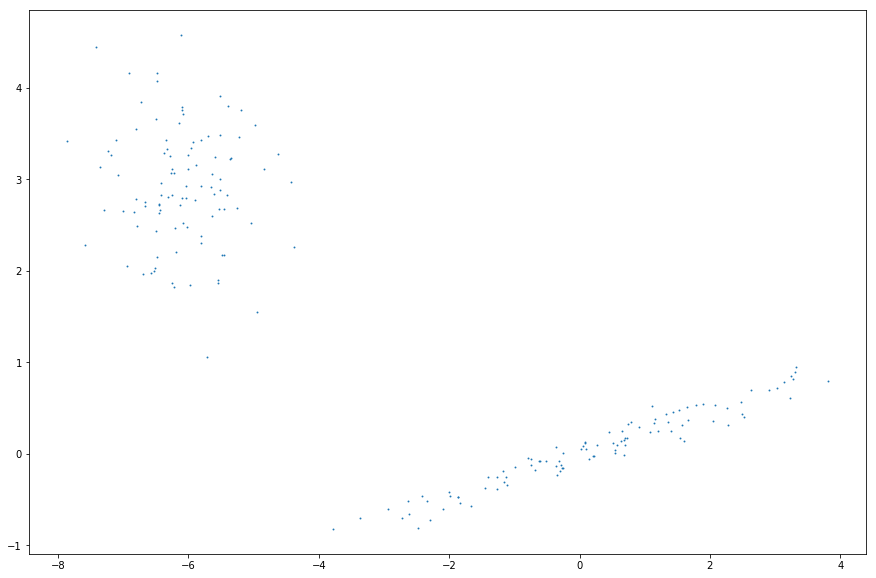

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import linalg
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
splot = plt.subplot(1, 1, 1)

splot.scatter(X[:,0],X[:,1], .8)
for i,_ in res:
    d = densities[i]
    mean, covar = d.mean, d.cov
    v, w = linalg.eigh(covar)
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])
    # Plot an ellipse to show the Gaussian component
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi  # convert to degrees
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

In [12]:
gmm = GaussianMixture(20)
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=20, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [13]:
densities =[]
for mean, var in zip(gmm.means_, gmm.covariances_):
    densities.append(multivariate_normal(mean, var))

In [8]:
cl = WeightEstimator(densities_dict=densities, select_threshold=1e-3)
cl.fit(X)


[ 0.  0.  0. ...,  0.  0.  0.]


In [10]:
cl.pi_final[cl.pi_final > 0]

array([ 0.00315446,  0.08360719,  0.00423585,  0.03617514,  0.15839016,
        0.14192934,  0.07263215,  0.00818737,  0.04433308,  0.06530192,
        0.09671991,  0.12418801,  0.08540385,  0.05481422,  0.02092736])

In [14]:
#On va essayer de faire une grille de l'espace et faire tourner EM et kde sur chaque portion
#pour construire le dictionaire


In [15]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X0 = sc.fit_transform(X)

In [16]:
k_em = 2
x_min, x_max, y_min, y_max = X0[:,0].min(), X0[:,0].max(), X0[:,1].min(), X0[:,1].max()
x_steps = np.linspace(x_min, x_max, grid_length)
y_steps = np.linspace(y_min, y_max, grid_length)
densities_dictionary = []
for grid_length in [5]:
    for idx, x_step in enumerate(x_steps[:-1]):
        for idy, y_step in enumerate(y_steps[:-1]):
            X_temp = X0[(X0[:,0] > x_step) & (X0[:,0] < x_steps[idx+1]) & (X0[:,1] > y_step) & (X0[:,1] < y_steps[idy+1]) ]
            if X_temp.shape[0] > k_em:
                gmm = GaussianMixture(3)
                gmm.fit(X_temp)
                for mean, var in zip(gmm.means_, gmm.covariances_):
                    densities_dictionary.append(multivariate_normal(mean, var))

NameError: name 'grid_length' is not defined

In [ ]:
cl = WeightEstimator(densities_dict=densities_dictionary, select_threshold=1e-10)

In [ ]:
cl.fit(X)

In [ ]:
res = cl.select_densities()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import linalg
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
splot = plt.subplot(1, 1, 1)

splot.scatter(X0[:,0],X0[:,1], .8)
for i,_ in res:
    d = densities_dictionary[i]
    mean, covar = d.mean, d.cov
    v, w = linalg.eigh(covar)
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])
    # Plot an ellipse to show the Gaussian component
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi  # convert to degrees
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle)
    ell.set_alpha(0.5)
    splot.add_artist(ell)

In [ ]:
best_bic = 1e10
for k in range(2,50):
    gmm = GaussianMixture(k)
    gmm.fit(X0)
    bic = gmm.bic(X0)
    if bic < best_bic:
        best_bic = bic
        score = gmm.score(X0)
        print score
        best_bic_param = (bic, score, gmm.covariances_, gmm.means_, gmm.weights_)
    

In [ ]:
best_bic_param

In [ ]:
densities_em = []
for cov, mean in zip(best_bic_param[2], best_bic_param[3]):
    densities_em.append(multivariate_normal(mean, cov))


In [ ]:
X, Y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
X_grid = np.vstack([X.ravel(), Y.ravel()]).T
X_grid

In [ ]:
def f(x):
    fk = np.array([d.pdf(x) for d in densities_em])
    return best_bic_param[-1].dot(fk)
f_em = np.apply_along_axis(f, 1, X0)
print np.log(f_em).sum()/X0.shape[0]

In [48]:
selected_densities_estim, weights_estim = np.array(zip(*res2))
f_weight_estim = np.apply_along_axis(lambda x: weights_estim.dot(np.array([densities[i].pdf(x) for i in selected_densities_estim.astype(int)])), 1, X0)
log_lik = np.log(f_weight_estim).sum()/X0.shape[0]
log_lik

-54.882235678734169

In [17]:
res

[(218, 0.06889282692661267),
 (221, 0.035466544430183496),
 (277, 0.10231750989867713),
 (278, 0.1456275319223059),
 (281, 0.10825819703086038),
 (338, 0.01906926295800231),
 (449, 0.04082022119365628),
 (509, 0.07447416210326328),
 (569, 0.126301475765866),
 (632, 0.1256061852841631),
 (692, 0.06665509095610522),
 (752, 0.037483876841484486),
 (812, 0.01421875846189462)]

In [17]:
from algorithm import WeightEstimator
cl = WeightEstimator(densities_dict=densities, select_threshold=1e-2)
cl.fit(X)
a = cl.pi_final

In [18]:
cd ../weight_vector_simulations_paper/weight_vector_estim_code/

[Errno 2] No such file or directory: '../weight_vector_simulations_paper/weight_vector_estim_code/'
/Users/mehdi/Dropbox/working folder/PHd/weight_vector_simulations_paper/weight_vector_estim_code


In [19]:
F = np.array([densities[i].pdf(X) for i in range(len(densities))]).T

In [20]:
def f0(pi,F):
    return -np.log((pi*F).sum(axis=1)).sum()

In [26]:
from sklearn.mixture import GaussianMixture
def mle_bic(X, kmax):
    best_bic = 1e10
    best_model = None
    for k in range(2,kmax):
        cl = GaussianMixture(n_components=k)
        cl.fit(X)
        bic = cl.bic(X)
        if bic < best_bic:
            best_bic = bic
            best_model = cl
    return best_bic, best_model

(956.66188635617254,
 GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
         means_init=None, n_components=2, n_init=1, precisions_init=None,
         random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
         verbose_interval=10, warm_start=False, weights_init=None))

In [38]:
cd /Users/mehdi/Documents/WorkingFolder/PHd/phd-clustering-models/tools/

/Users/mehdi/Dropbox/working folder/PHd/phd-clustering-models/tools


In [41]:
from gm_tools import gaussian_mixture_sample, gm_params_generator, best_cont_matrix
weights, centers, cov = gm_params_generator(2,5)
X, Y = gaussian_mixture_sample(weights, centers, cov, 1000)

In [42]:
mle_bic(X,15)

(-3015.5472245981714,
 GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
         means_init=None, n_components=5, n_init=1, precisions_init=None,
         random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
         verbose_interval=10, warm_start=False, weights_init=None))

In [47]:
cd /Users/mehdi/Documents/WorkingFolder/PHd/weight_vector_simulations_paper/weight_vector_estim_code/

/Users/mehdi/Dropbox/working folder/PHd/weight_vector_simulations_paper/weight_vector_estim_code


In [48]:
from DensitiesGenerator import DensityGenerator

In [49]:
dg = DensityGenerator(n_pdf= 1000)

In [58]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import laplace
from scipy.integrate import simps
nodes_gauss = [0, 0.2, 0.4, 0.6, 0.8, 1]
var_list = [1, 10**(-1), 10**(-2), 10**(-3)]
densities = []
for m in nodes_gauss:
    for var in var_list:
        densities.append(multivariate_normal(m, var))
scales =[0.05, 0.1, 0.2, 0.5, 1]
nodes_lapl = [0, 0.2, 0.4, 0.6, 0.8, 1]
for m in nodes_lapl:
    for scale in scales:
        densities.append(laplace(loc=m, scale=scale))
X = dg.generate_uniform(n_points=100)


In [63]:
Y = X[0].reshape(-1,1)

In [64]:
mle_bic(Y,15)

(47.474573931065919,
 GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
         means_init=None, n_components=3, n_init=1, precisions_init=None,
         random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
         verbose_interval=10, warm_start=False, weights_init=None))

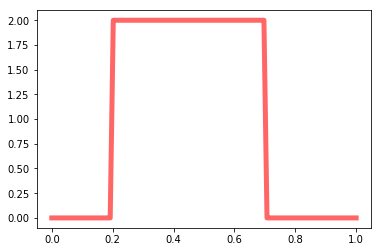

In [138]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import uniform
rv = uniform(0.2,0.5)
x = np.linspace(0,1, 100)
plt.plot(x, rv.pdf(x),'r-', lw=5, alpha=0.6, label='uniform pdf')

In [150]:
densities = []
for i in range(50):
        densities.append(uniform_nonzero(i*1./50,1./50))

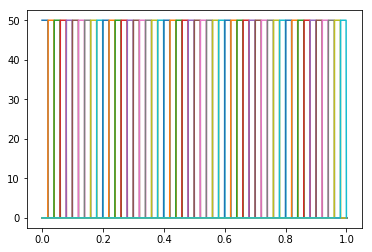

In [151]:
x = np.linspace(0, 1, 1000)
for d in densities:
    plt.plot(x, d.pdf(x))

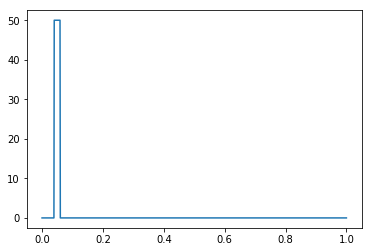

In [152]:
plt.plot(x, densities[2].pdf(x))

# Generation du dictionnaire

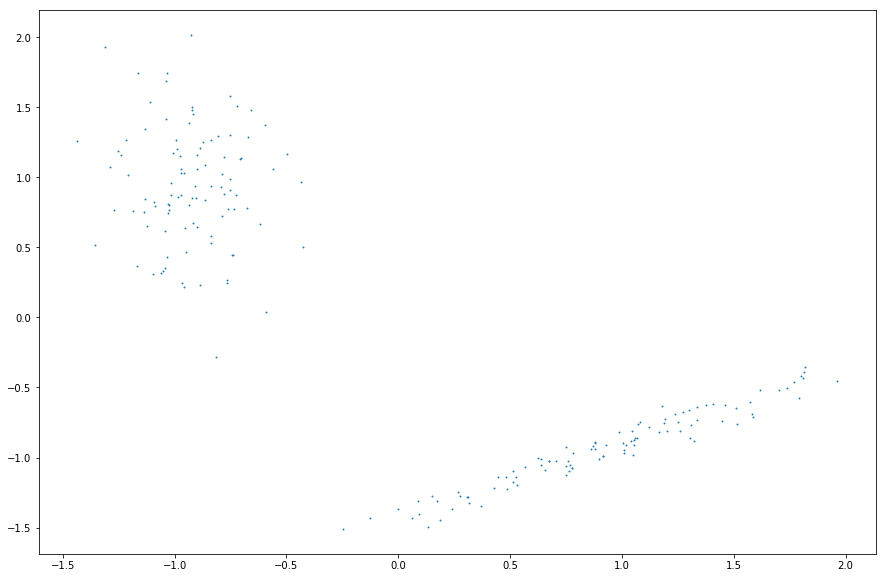

In [17]:
X = sc.fit_transform(X)
plt.scatter(X[:,0],X[:,1], .8)

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [19]:
pc = PCA(2)
sc = StandardScaler()

In [31]:
X_pca = pc.fit_transform(sc.fit_transform(X))
pc.components_

array([[-0.70710678,  0.70710678],
       [-0.70710678, -0.70710678]])

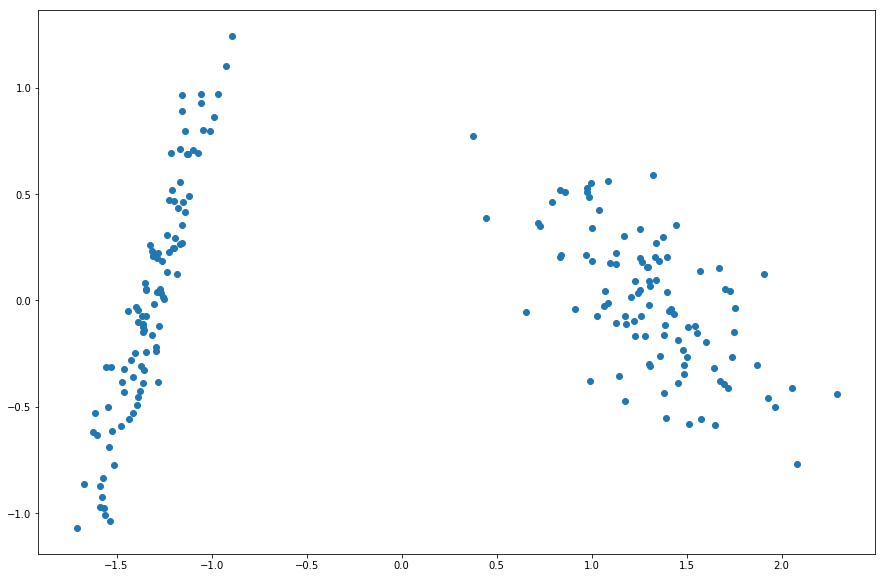

In [32]:
plt.scatter(X_pca[:,0], X_pca[:,1])

In [22]:
from sklearn.cluster import KMeans
km = KMeans(5)
X_temp0= km.fit_predict(X_pca[:,0].reshape(-1,1))
X_temp1= km.fit_predict(X_pca[:,1].reshape(-1,1))

In [23]:
X_temp1[0]

2

In [43]:
kmeans = KMeans(2)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [46]:
y = kmeans.labels_

In [51]:
y[np.where(y==1)]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [122]:
cd ../tools/

/Users/mehdi/Dropbox/working folder/PHd/phd-clustering-models/tools


In [159]:
from gm_tools import gaussian_mixture_sample, gm_params_generator, best_cont_matrix
weights, centers, cov = gm_params_generator(10,3)
X, Y = gaussian_mixture_sample(weights, centers, cov, 1000)

In [160]:
X

array([[ 0.03717608, -1.15220815, -0.63477926, ...,  1.30554143,
         2.22423824,  1.51622318],
       [-0.07206821, -0.91839595, -0.62778374, ...,  1.43750006,
         2.33168   ,  1.69296087],
       [ 1.47955317, -1.10682111, -2.62963366, ...,  0.3303743 ,
         2.13341828, -0.6861456 ],
       ..., 
       [-0.43803426, -1.28543693, -0.91326653, ...,  0.9660687 ,
         1.85596215,  1.45977998],
       [-0.43260847, -1.55075385, -0.80510266, ...,  1.07989485,
         1.7797362 ,  1.39173138],
       [-0.26803614, -1.35060715, -0.89429421, ...,  1.06051135,
         1.72468985,  1.45074475]])

In [167]:
dg = DictionaryGenerator(max_pca_comp=5)

In [168]:
dg.fit(X )
dg.densities

[[<scipy.stats._multivariate.multivariate_normal_frozen at 0x1146ec4d0>,

In [79]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(2)
gm.fit(X)
gm.covariances_

array([[[ 0.03863992, -0.0073086 ],
        [-0.0073086 ,  0.17751361]],

       [[ 0.25322626,  0.13426231],
        [ 0.13426231,  0.07563479]]])

In [173]:
import pypmc

In [181]:
from pypmc.sampler.importance_sampling import ImportanceSampler


In [175]:
for i in range(X.shape[1]):
    print X[:,i].min(), X[:,i].max()

-2.68449893153 1.9113202268
-1.88855044146 1.60213288427
-2.74197546065 -0.32963205798
-2.81993508036 2.55187166683
-2.01797346592 1.08148826271
-2.48619196342 0.0539009970857
-2.75843006585 0.557241085456
-2.48493987178 1.6740202351
1.29569806977 2.64557118809
-1.73689129564 1.95689548016


In [176]:
from pypmc.tools.indicator import merge_function_with_indicator

# define indicator
ind_lower = [-3 for _ in range(X.shape[1])]
ind_upper = [3 for _ in range(X.shape[1])]
ind = pypmc.tools.indicator.hyperrectangle(ind_lower, ind_upper)


In [298]:
from pypmc.density.mixture import create_gaussian_mixture



class Gaussian_mixture_gen(object):
    """
    Simple gaussian mixture class
    """
    def __init__(self, p, weights):
        self.K = len(weights)
        self.weights = weights
        self.centers = self.binary_centers(self.K, p)
        self.cov = np.array([1e-2*np.diag(np.ones(p)) for _ in range(self.K)])
        
    def binary_centers(self, K,p):
        if K > 2**p:
            print "Warning: not enough nodes"
            K_ = 2**p
        else:
            K_ = K
        centers = []
        for i in range(K_):
            bin_array = list(bin(i).split("b")[1])
            zeros_arr = [0]*(p-len(bin_array))
            centers.append(np.array(map(int, zeros_arr+bin_array)))
        return np.array(centers)
    
    def get_params(self):
        return self.centers, self.cov
    
    def sample(self, N):
        mixture = create_gaussian_mixture(self.centers, self.cov, self.weights)
        return mixture.propose(N)
        

In [187]:
y = np.ma.array([1, 2, 3], mask = [0, 1, 0])

masked_array(data = [1 -- 3],
             mask = [False  True False],
       fill_value = 999999)

In [238]:
np.diag(np.ones(5))

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]])

In [234]:
binary_centers(50,22)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       ..., 
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [299]:
K = 10
N = 100
p = 5
weights = 1./K*np.ones(K)
gg = Gaussian_mixture_gen(p, weights)
X2 = sc.fit_transform(gg.sample(N))

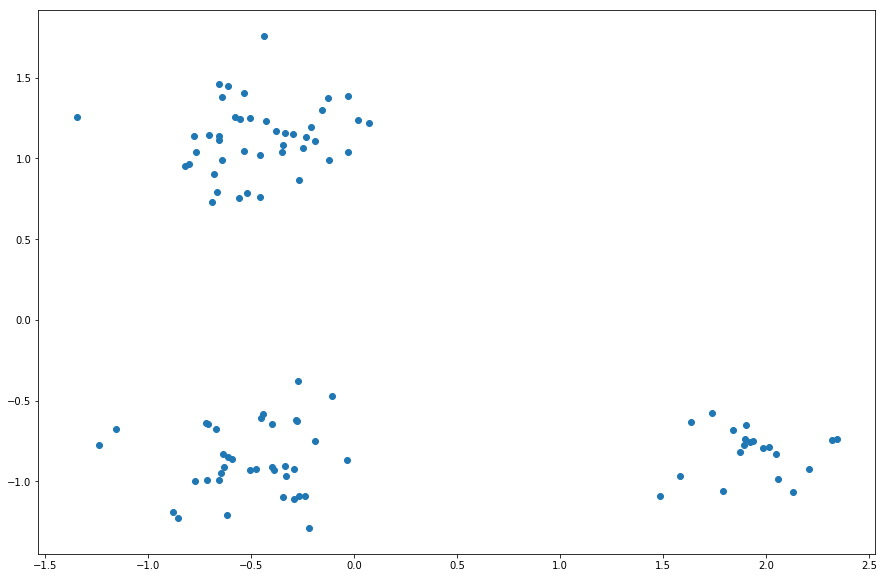

In [300]:
plt.scatter(X2[:,1], X2[:,2])

In [301]:
gg.get_params()

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 1],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 0, 1],
        [0, 0, 1, 1, 0],
        [0, 0, 1, 1, 1],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 1]]), array([[[ 0.01,  0.  ,  0.  ,  0.  ,  0.  ],
         [ 0.  ,  0.01,  0.  ,  0.  ,  0.  ],
         [ 0.  ,  0.  ,  0.01,  0.  ,  0.  ],
         [ 0.  ,  0.  ,  0.  ,  0.01,  0.  ],
         [ 0.  ,  0.  ,  0.  ,  0.  ,  0.01]],
 
        [[ 0.01,  0.  ,  0.  ,  0.  ,  0.  ],
         [ 0.  ,  0.01,  0.  ,  0.  ,  0.  ],
         [ 0.  ,  0.  ,  0.01,  0.  ,  0.  ],
         [ 0.  ,  0.  ,  0.  ,  0.01,  0.  ],
         [ 0.  ,  0.  ,  0.  ,  0.  ,  0.01]],
 
        [[ 0.01,  0.  ,  0.  ,  0.  ,  0.  ],
         [ 0.  ,  0.01,  0.  ,  0.  ,  0.  ],
         [ 0.  ,  0.  ,  0.01,  0.  ,  0.  ],
         [ 0.  ,  0.  ,  0.  ,  0.01,  0.  ],
         [ 0.  ,  0.  ,  0.  ,  0.  ,  0.01]],
 
        [[ 0.01,  0.  ,  0.  ,  0.  ,  0.  ],
    

In [9]:
from tools import get_results
import pickle

In [8]:
folder = "/Users/mehdi/temp/simus weight vector/GLU_valid_2017-06-12_18.37.51/"
df = get_results(folder)

/usr/local/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.18.1 when using version 0.18. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


KeyboardInterrupt: 

In [11]:

a = pickle.load(open("/Users/mehdi/temp/simus weight vector/GLU_valid_2017-06-12_18.37.51/res_K0N100_00f94cec-513f-4268-9d05-57dedcbeea42"))

In [14]:
a['rect_mle_time',
 'rect_mle_bic_time',
 'uniform_kde']

KeyError: ('rect_mle_time', 'rect_mle_bic_time', 'uniform_kde')

# nouveaux clusters


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
%matplotlib inline

In [66]:
p = 3
cov = np.array([[1,0],[0,10]])

In [136]:
N=1000
means = [[0.1, 0.3], [0.3,0.7], [0.6, 0.1], [0.7,0.5]]
cov = 1e-3*np.array([
        np.array([[0.5, 0],
                [0, 8]]),
        np.array([[1, -1.5],
                [-1.5, 4]]),
        np.array([[6, 0],
                [0, 0.2]]),
        np.array([[5, 3],
                [3, 2]])
      ])
params = zip(means, cov)
X = np.zeros([4*N,2])
X[:N,:]=multivariate_normal(params[0][0], params[0][1]).rvs(N)
i=1
for m, c in params[1:]:
    X[i*N:(i+1)*N,:] = multivariate_normal(m, c).rvs(N)
    i+=1


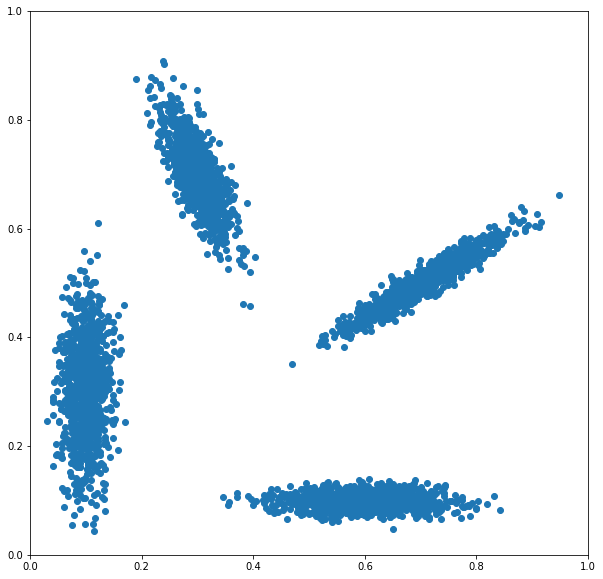

In [137]:
plt.figure(figsize=[10,10])
plt.xlim([0,1])
plt.ylim([0,1])

plt.scatter(X[:,0], X[:,1])

In [70]:
np.vstack([np.array([1,4]),np.array([2,4])])

array([[1, 4],
       [2, 4]])

In [135]:
X.shape

(1000, 2)

In [38]:
#Essai en dim p

# On genere les params et on selectionne si ca nous convient
p = 5
K = 2
N = 100
params = []
for _ in range(K):
    A = np.random.random([p, p])
    d = np.ones(p)
    d[np.random.randint(p)] = 10
    C = 1e-3*(np.diag(d)) #A.dot(A.T)
    v = np.random.random(p)
    m = v
    params.append((m, C))
X = np.zeros([4*N,p])
X[:N,:]=multivariate_normal(params[0][0], params[0][1]).rvs(N)
i=1
for m, c in params[1:]:
    X[i*N:(i+1)*N,:] = multivariate_normal(m, c).rvs(N)
    i+=1

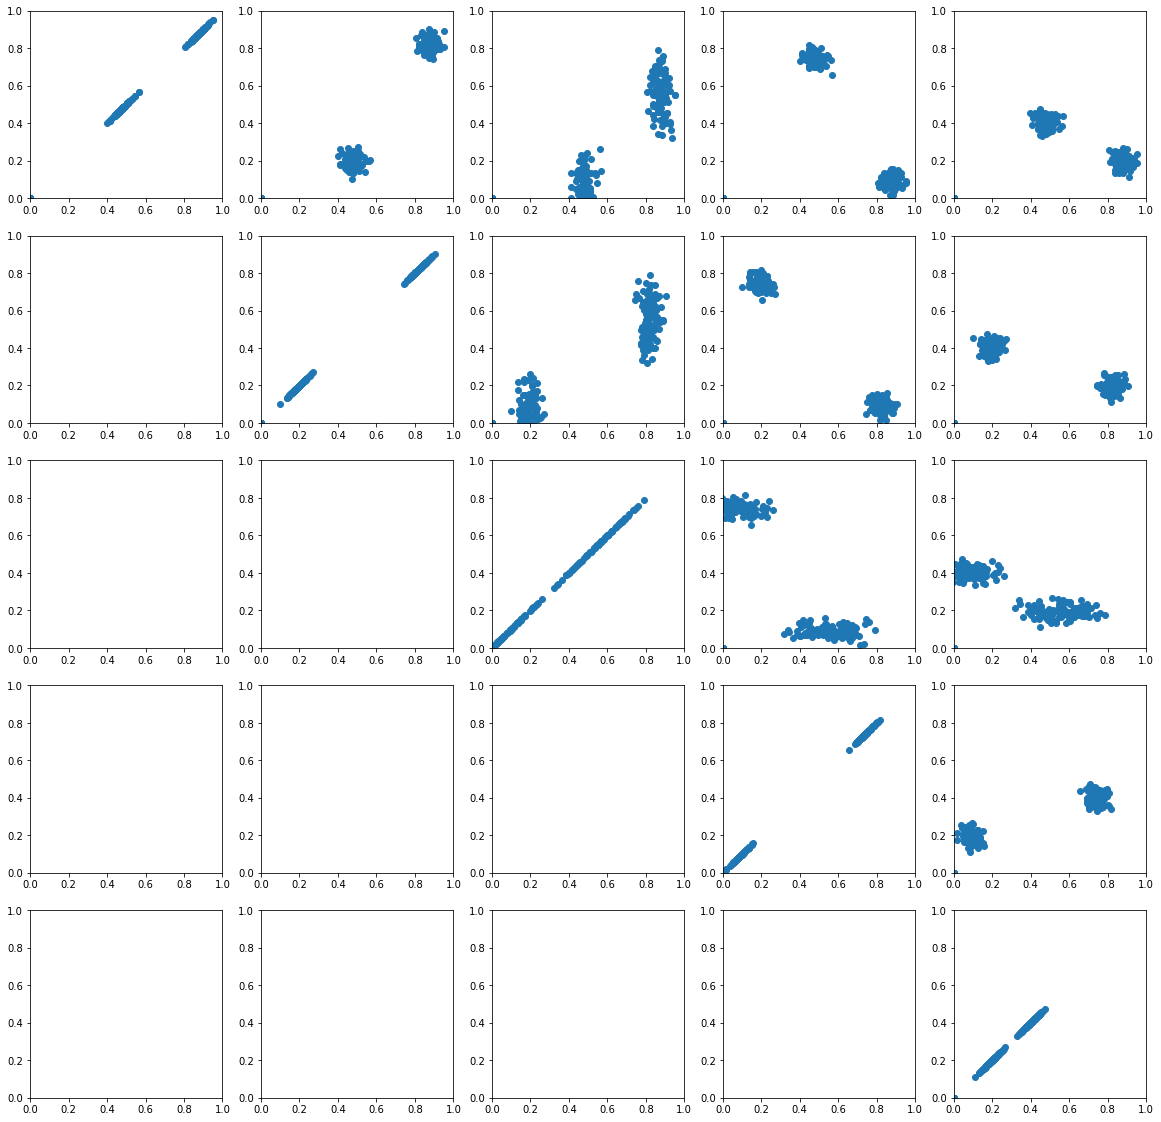

In [39]:
fig, ax = plt.subplots(5,5, figsize=(20,20))
for i in range(p):
    for j in range(i, p):
        ax[i][j].set_xlim([0,1])
        ax[i][j].set_ylim([0,1])        
        ax[i][j].scatter(X[:,i], X[:,j])

In [228]:
np.diag(np.random.normal(np.random.randint(5),1).,5,p))

array([[3, 0, 0, 0, 0],
       [0, 3, 0, 0, 0],
       [0, 0, 3, 0, 0],
       [0, 0, 0, 3, 0],
       [0, 0, 0, 0, 3]])

In [243]:
np.random.normal(np.random.randint(50),1,p)

array([ 40.7588952 ,  41.3955466 ,  41.06611134,  42.40520043,  41.77968484])

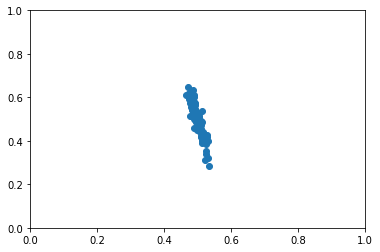

In [27]:
d = np.ones(p)
d[np.random.randint(p)] =5
np.diag(d)

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  5.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]])

In [108]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm


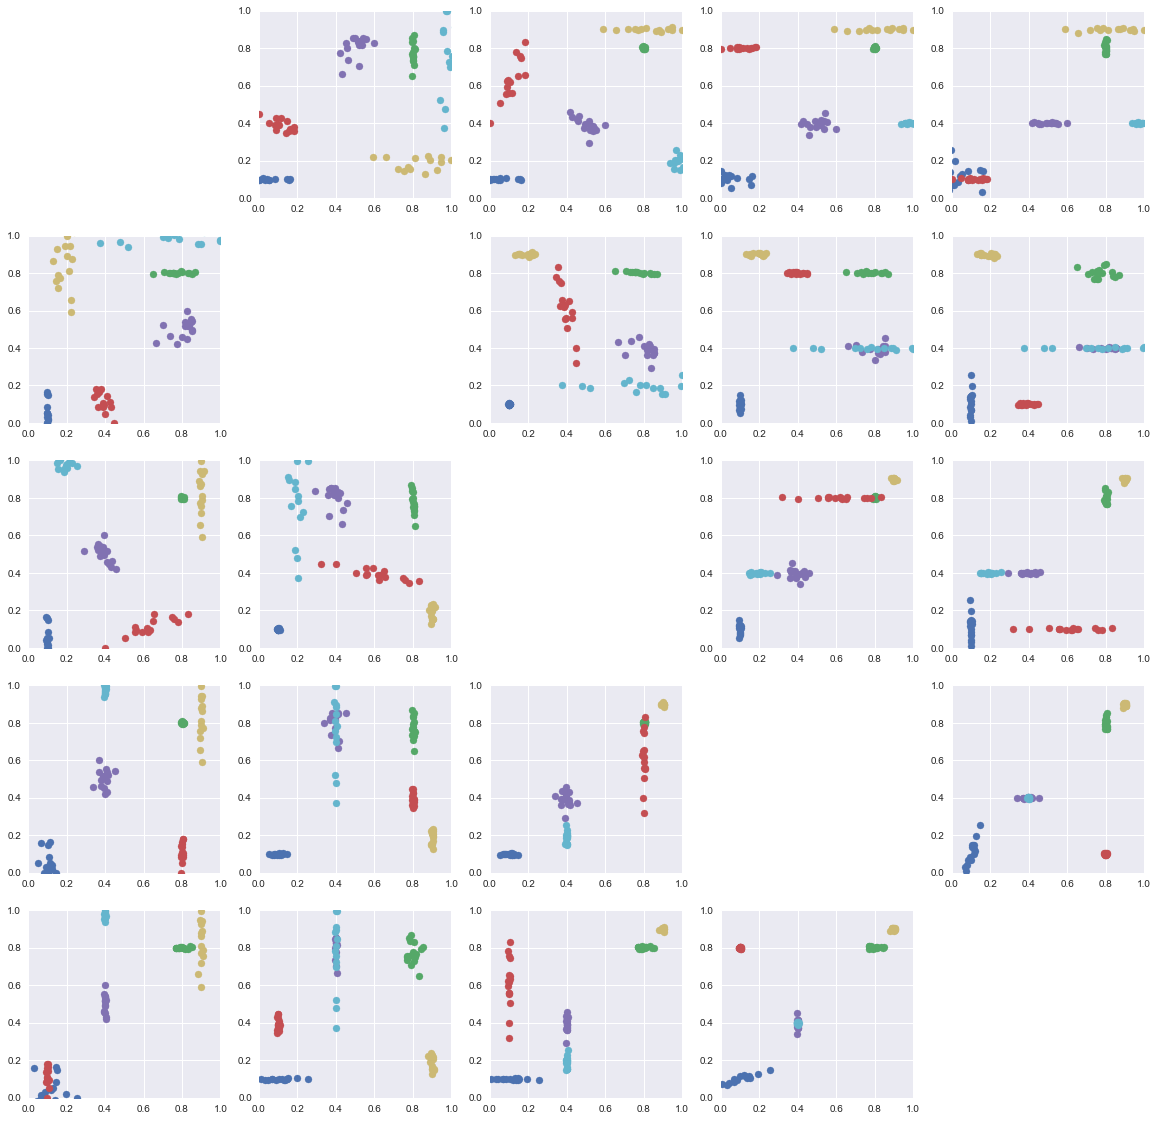

In [540]:
class BasicGen(object):
    #dirty gross generator
    def __init__(self, dim=5):
        self.dim = dim
        self.params = [
            (np.array([[3, 0, 0, 0, 0],
                      [0, 0.1, 0, 0, 0],
                      [0, 0, 0.1, 0, 0],
                      [0, 0, 0, 0.1, 1],
                      [0, 0, 0, 1, 3]]), 
             np.array([0.1, 0.1, 0.1, 0.1, 0.1])), 
            (np.array([[0.1, 0, 0, 0, 0],
                            [0, 2, -0.2, 0, 0],
                            [0, -0.2, 0.1, 0, 0],
                            [0, 0, 0, 0.1, 0],
                            [0, 0, 0, 0, 1]]),
             np.array([0.8, 0.8, 0.8, 0.8, 0.8])), 
            (np.array([[1, 0.1, 1.9, 0, 0],
                       [0.1, 0.5, -1, 0, 0],
                       [1.9, -1, 3, 0, 0],
                       [0, 0, 0, 0.1, 0],
                       [0, 0, 0, 0, 0.1]]),
             np.array([0.1, 0.4, 0.6, 0.8, 0.1])),
            (np.array([[0.5, 1, -1, 0, 0],
                       [1, 2, 0, 0, 0],
                       [-1, 0, 0.1, 0, 0],
                       [0, 0, 0, 1, 0],
                       [0, 0, 0, 0, 0.1]]),
             np.array([0.5, 0.8, 0.4, 0.4, 0.4])),
            (np.array([[4, 0, 0, 0, 0],
                       [0, 1, 0, 0, 0],
                       [0, 0, 0.2, 0, 0],
                       [0, 0, 0, 0.2, 0],
                       [0, 0, 0, 0, 0.2]]),
             np.array([0.9, 0.2, 0.9, 0.9, 0.9])),
            (np.array([[0.1, 0, -1, 0, 0],
                       [0,  6, 0,   0, 0],
                       [-1, 0, 0.1, 0, 0],
                       [0, 0, 0, 0.1, 0],
                       [0, 0, 0, 0, 0.1]]),
             np.array([1, 0.8, 0.2, 0.4, 0.4]))
        ]
        self.change_dim(self.dim)
        self.means, self.variances = zip(*self.params)
    
    def change_dim(self, p):
        params = []
        for cov, m in self.params:
            C = cov[:p,:p]
            params.append((m[:p], 1e-3*C.T.dot(C)))
        self.params = params
    
    def get_params(self):
        return self.means, self.variances
    
    def sample(self, N, with_ids = False):
        #We generate a dataset with specific data
        K = len(self.params)
        X = multivariate_normal(self.params[0][0], self.params[0][1]).rvs(N/K)
        ids = np.ones(N/K)
        i = 2
        for m, cov in self.params[1:]:
            X = np.vstack([X, multivariate_normal(m, cov).rvs(N/K)])
            ids = np.hstack([ids, i*np.ones(N/K)])
            i+=1
        if with_ids:
            X = np.hstack([X, ids.reshape(-1,1)])
        np.random.shuffle(X)
        return X


means, covas = gg.get_params()
p=5
gg = BasicGen(dim=p)
X_ = gg.sample(100, with_ids=True)
ids = X_[:,-1]
X = X_[:,:-1]
fig, ax = plt.subplots(p,p, figsize=(20,20))
#cm = LinearSegmentedColormap.from_list(
#        cm.cmap_name, colors, N=n_bin)
for k in set(ids):
    for i in range(p):
        for j in range(p):
            if i!=j :
                ax[i][j].set_xlim([0,1])
                ax[i][j].set_ylim([0,1])        
                ax[i][j].scatter(X[ids==k][:,i], X[ids==k][:,j], cmap="cmap_name_r")
            else:
                ax[i][j].set_axis_off()

fig.savefig("data")


In [236]:
len(X)

96

NameError: name 'XA' is not defined

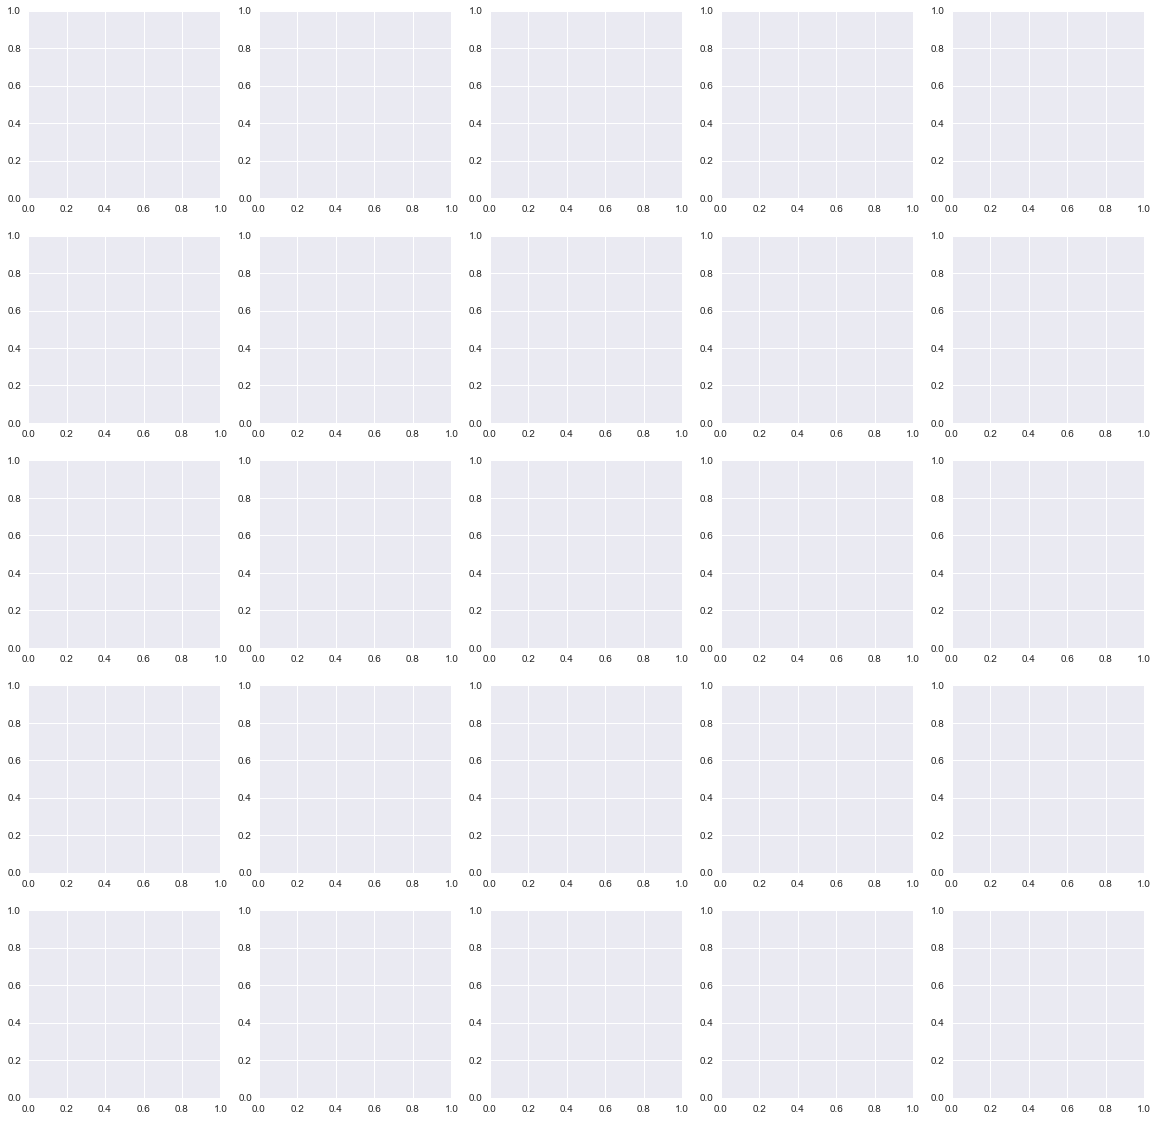

In [237]:


fig, ax = plt.subplots(p,p, figsize=(20,20))
for i in range(p):
    for j in range(i, p):
        ax[i][j].set_xlim([0,1])
        ax[i][j].set_ylim([0,1])        
        ax[i][j].scatter(XA[:,i], XA[:,j], color='r')
        ax[i][j].scatter(XB[:,i], XB[:,j], color='b')
        ax[i][j].scatter(XC[:,i], XC[:,j], color='g')
        ax[i][j].scatter(XD[:,i], XD[:,j], color='y')
fig.show()


In [195]:
E = np.diag([0.1,3,0.1,0.1,0.1])

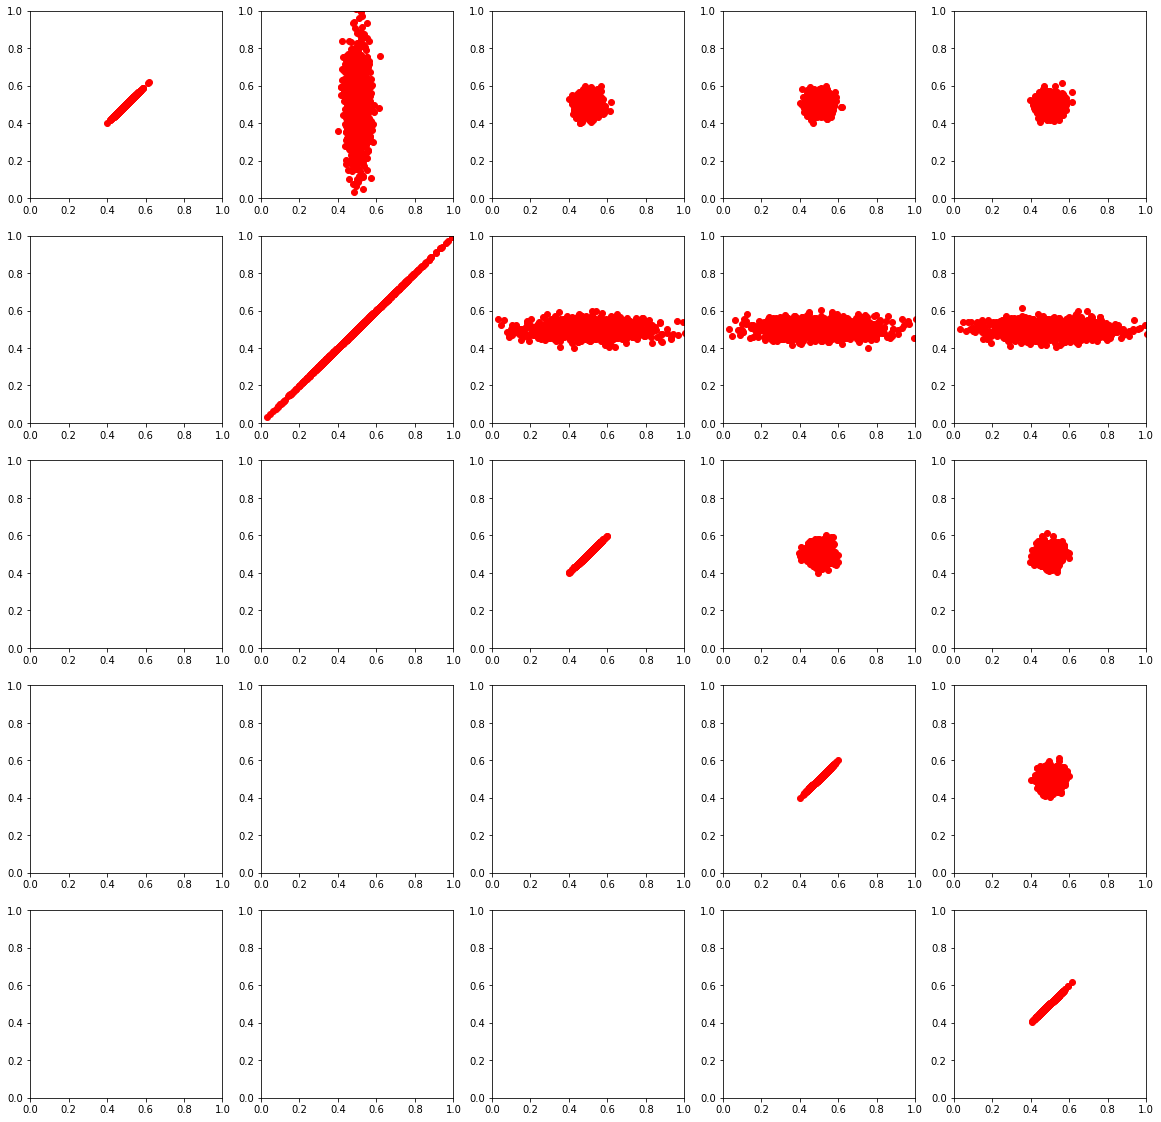

In [199]:
D = np.array([[1,0,0,0,0],
              [0,1,0,0,0],
              [0,0,1,0,0],
              [0,0,0,1,0],
              [0,0,0,0,1]])
C = 1e-2*D.dot(E.dot(D.T))
X_test = multivariate_normal(np.array([0.5,0.5,0.5,0.5,0.5]), C).rvs(1000)
fig, ax = plt.subplots(5,5, figsize=(20,20))
for i in range(p):
    for j in range(i, p):
        ax[i][j].set_xlim([0,1])
        ax[i][j].set_ylim([0,1])        
        ax[i][j].scatter(X_test[:,i], X_test[:,j], color='r')
fig.show()


In [224]:
X[:,range(3)]

array([[-0.10920323,  0.10017485,  0.09772462],
       [ 0.21797792,  0.1014157 ,  0.09953745],
       [ 0.23654265,  0.10216187,  0.09944494],
       ..., 
       [ 0.44538607,  0.42662045,  0.50954464],
       [ 0.46592992,  0.39846962,  0.38445325],
       [ 0.52241069,  0.52547636,  0.33791091]])

In [252]:
a = [1,2,3]
np.random.shuffle(a)
print a[:1]

[1]


In [249]:
D[:2,:2]

array([[1, 0],
       [0, 1]])

In [1]:
from simu_clustering import simu, GaussMixtureDensity

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
simu(100, 4, 3)

KeyboardInterrupt: 

In [21]:
from pypmc.density.mixture import create_gaussian_mixture


In [11]:
gg = BasicGen(3)
means, covar = gg.get_params()

In [19]:
create_gaussian_mixture(means, covar, 1./4*np.ones(4))

In [135]:
from simu_clustering import simu

# Analyse resultats clustering

In [139]:
from os import listdir
from os.path import isfile, join

simu_folder = "/Users/mehdi/Downloads/dg_2017-07-06_15.35.51/"
folder  = simu_folder
#folder = "/Users/mehdi/Downloads/"+simu_folder+"/"
onlyfiles = [f for f in listdir(folder) if (isfile(join(folder, f)) and f.startswith("res_K"))]

In [140]:
import pickle
data = []
for f in onlyfiles:
    data.append(pickle.load(open(simu_folder+"/"+f)))

In [146]:
import pandas as pd
df = pd.DataFrame(data)

In [147]:
df.head()

,EM_KL,EM_l2,EM_time,K,KdeCV_KL,KdeCV_l2,KdeCV_time,MLE_KL,MLE_l2,MLE_time,N,p
0,10.199030,44.787881,3.815007,6,6.597285,44.531378,5.640508,9.650484,44.363406,0.368354,1000,3
1,10.199030,44.787881,3.100750,6,6.597285,44.531378,7.252925,9.650484,44.363406,0.253355,1000,3
2,9.799657,44.877959,3.107343,6,6.642765,44.662089,7.817395,10.688820,44.427231,0.438518,1000,3
3,10.203989,43.852161,3.546593,6,6.702541,44.099749,5.455646,9.491775,44.823550,0.531338,1000,3
4,9.878411,44.041220,4.347214,6,6.855777,44.355330,8.906913,5.656571,44.154620,0.418076,1000,3


In [169]:
df_temp = df[(df.p==5) & (df.K == 6)]
df_temp2 = df_temp.drop(['p', 'K', 'EM_time', 'KdeCV_time', 'MLE_time'], axis=1)
df2 = pd.melt(df_temp2, id_vars=["N"], var_name="Type", value_name="loss")
set(df2["Type"])

{'EM_KL', 'EM_l2', 'KdeCV_KL', 'KdeCV_l2', 'MLE_KL', 'MLE_l2'}

In [177]:

def extract_type(row):
    if "l2" in row["Type"]:
        metric = "L2"
    else:
        metric = "KL"
    if "EM" in row["Type"]:
        method = "EM"
    elif "MLE" in row["Type"]: 
        method = "MLE"
    elif "Kde" in row["Type"]:
        method = "KDE CV"
    else:
        method = "0"
    return pd.Series({'method': method, "metric": metric})

def remove_method_comp(row):
    comp = row["comp"]
    comp = int(comp.split("_")[1])
    return pd.Series({'comp':comp, "N":row["N"],"weight": row["weight"], "method":row["method"] })

#df3 = pd.melt(df2, id_vars=["N"], var_name="comp", value_name="weight")
df3 = pd.concat([df2, df2.apply(extract_type, axis =1)], axis=1)
#df5 = df4.apply(remove_method_comp, axis=1)


,N,Type,loss,method,metric
0,1000,EM_KL,inf,EM,KL
1,1000,EM_KL,inf,EM,KL
2,1000,EM_KL,inf,EM,KL
3,1000,EM_KL,inf,EM,KL
4,1000,EM_KL,inf,EM,KL
5,1000,EM_KL,inf,EM,KL
6,1000,EM_KL,inf,EM,KL
7,1000,EM_KL,inf,EM,KL
8,1000,EM_KL,inf,EM,KL
9,1000,EM_KL,inf,EM,KL


In [179]:
df4 = df3.replace([np.inf, -np.inf], np.nan).dropna(subset=["loss"], how="all")


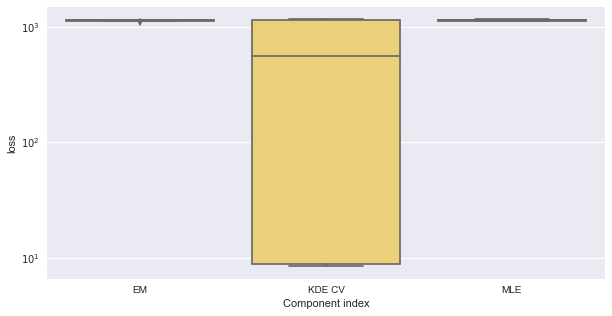

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
boxplot = sns.boxplot(x="method", y="loss", data=df4[df4["N"]==500],
                     palette=["#ff6666", "#ffd966", "#b3ff66"])
for patch in boxplot.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 1))
boxplot.set_xlabel('Component index')
boxplot.set_yscale("log")
sns_plot = boxplot.get_figure()

In [182]:
from simu_clustering import BasicGen

In [238]:
bg = BasicGen(dim=2)

In [535]:
X = bg.sample(100)

LinAlgError: singular matrix

In [189]:
def select_eigvals(eigval):
    return np.array([e for e in eigval if e > 2.858*np.median(eigval)])

In [190]:
eigval, eigvect =  np.linalg.eig(1./X.shape[0]*X.T.dot(X))

In [191]:
from sklearn.decomposition import PCA

In [193]:
pc = PCA(4)
pc.fit(X)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [214]:
pc0= pc.components_[0]+np.mean(X, axis=0)
pc1= pc.components_[1]+np.mean(X, axis=0)
pc2= pc.components_[2]+np.mean(X, axis=0)
pc3= pc.components_[3]+np.mean(X, axis=0)


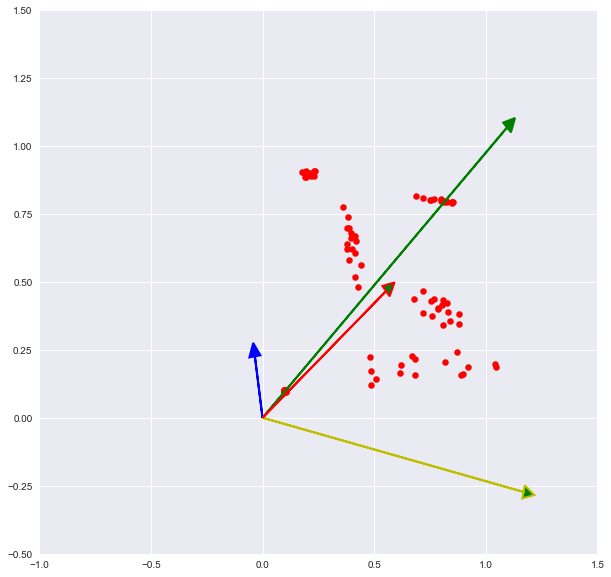

In [215]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.xlim(-1, 1.5)
plt.ylim(-0.5, 1.5)
#plt.zlim(-1,2)
x,y = X[:,1], X[:,2]
ax.scatter(x, y , c = 'red', marker = '.', linewidth = 3)
ax.arrow(0, 0, pc0[0], pc0[1], lw = 2, head_width=0.05, head_length=0.05, fc='b', ec='b')
ax.arrow(0, 0, pc1[0], pc1[1], lw = 2, head_width=0.05, head_length=0.05, fc='g', ec='g')
ax.arrow(0, 0, pc2[0], pc2[1], lw = 2, head_width=0.05, head_length=0.05, fc='g', ec='y')
ax.arrow(0, 0, pc3[0], pc3[1], lw = 2, head_width=0.05, head_length=0.05, fc='g', ec='r')

plt.show()

In [536]:
for m, c in bg.params:
    try:
        print"ok"
        multivariate_normal(m,c)
    except:
        print "error"
        mean = m
        cov = c

ok
ok
ok
ok
error
ok
ok


In [539]:
cov*1e3

array([[ 1.25,  2.5 ],
       [ 2.5 ,  5.  ]])

# On reprend tout

In [438]:
covs = 1e-3*np.array([
        np.array([[10, 0, 3],
                  [0, 0.1, 0],
                  [3, 0, 1]]),
        
        np.array([[0.1,0,0],
                  [0, 2 ,-4],
                  [0, -4, 10]]),
        
        np.array([[0.1, 0.3, 0],
                  [0.3, 20, 0],
                  [0, 0, 0.5]]),
        ])
means = [np.array([0.1, 0.1, 0.1]),
         np.array([0.1, 0.8 , 0.8]),
         np.array([0.6, 0.2, 0.8]),
        ]
X = multivariate_normal(means[0], covs[0]).rvs(100)
X = np.vstack([X, multivariate_normal(means[1], covs[1]).rvs(100)])
X = np.vstack([X, multivariate_normal(means[2], covs[2]).rvs(100)])


In [454]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [455]:
pc = PCA(3)
pc.fit(X_sc)
comps = pc.components_

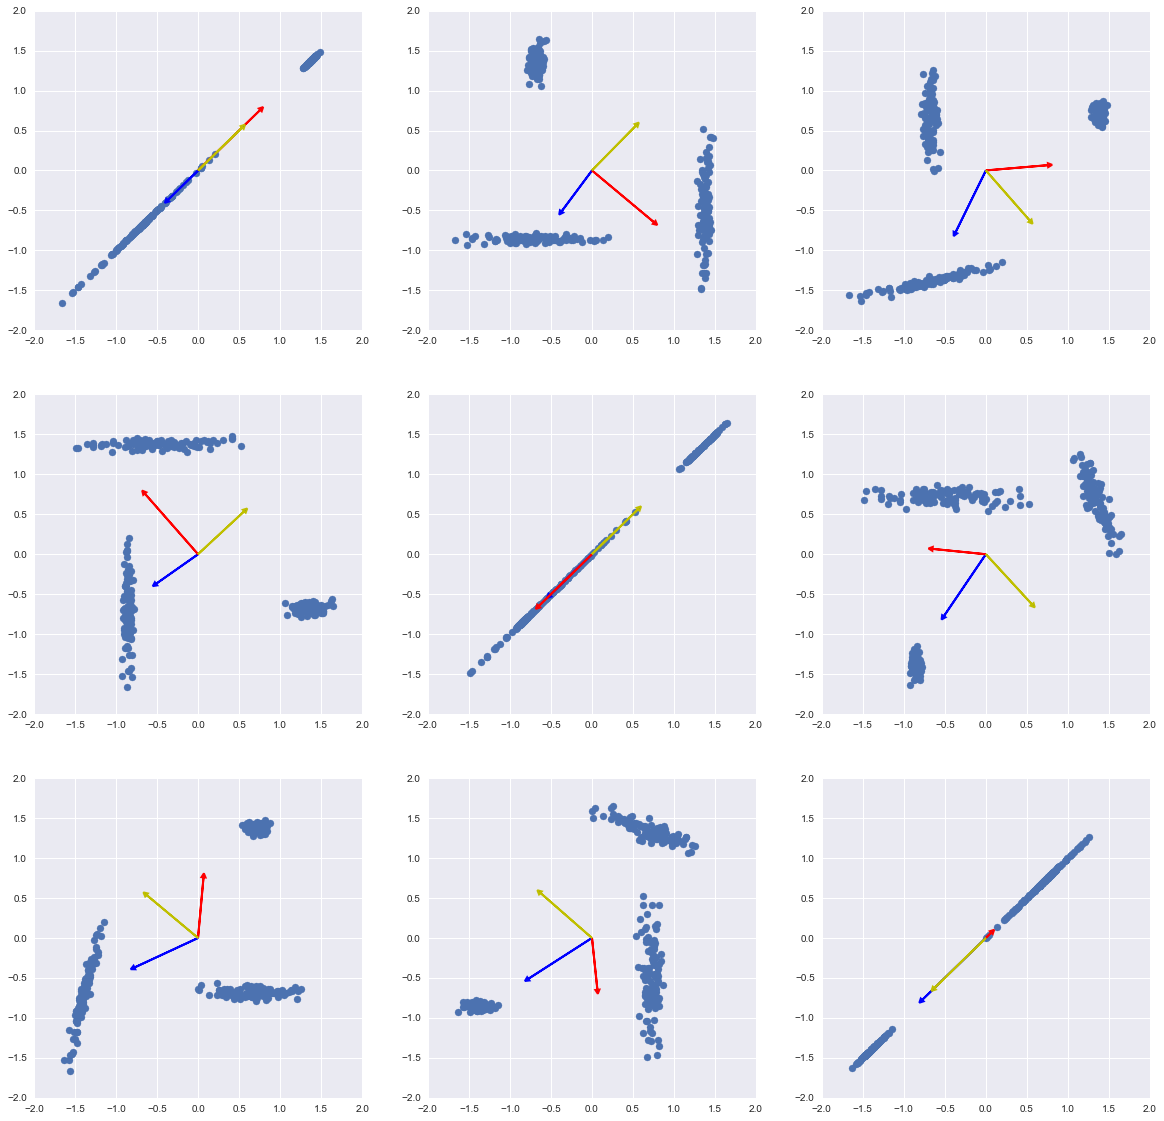

In [456]:
fig, ax = plt.subplots(3,3,figsize = (20,20))

for i in range(3):
    for j in range(3):
        ax[i][j].set_ylim([-2, 2])
        ax[i][j].set_xlim([-2, 2])
        ax[i][j].scatter(X[:,i], X[:, j])
        ax[i][j].arrow(X.mean(axis=0)[i], X.mean(axis=0)[j], comps[0][i]+X.mean(axis=0)[i], comps[0][j]+X.mean(axis=0)[j], lw = 2, head_width=0.05, head_length=0.05, fc='b', ec='b')
        ax[i][j].arrow(X.mean(axis=0)[i], X.mean(axis=0)[j], comps[1][i]+X.mean(axis=0)[i], comps[1][j]+X.mean(axis=0)[j], lw = 2, head_width=0.05, head_length=0.05, fc='b', ec='r')
        ax[i][j].arrow(X.mean(axis=0)[i], X.mean(axis=0)[j], comps[2][i]+X.mean(axis=0)[i], comps[2][j]+X.mean(axis=0)[j], lw = 2, head_width=0.05, head_length=0.05, fc='b', ec='y')



In [442]:
comps

array([[-0.13400509, -0.64346251, -0.75365685],
       [ 0.74096049, -0.57006625,  0.35496763],
       [ 0.65804269,  0.51086248, -0.55317207]])

In [443]:
eigval, eigvect =  np.linalg.eig(1./X.shape[0]*X.T.dot(X))

In [444]:
eigvect

array([[-0.33513071, -0.69937884, -0.63131343],
       [-0.52796199,  0.69437718, -0.48897491],
       [-0.78034835, -0.16943899,  0.60195256]])

In [505]:
select_eigvals(eigval)

([0.68839245848415875, 0.10335285753960993], [0, 1])

In [515]:
eigval[:2]

array([ 0.68839246,  0.10335286])

In [504]:
def select_eigvals(eigval):
    #select singular values according to 
    #"The Optimal Hard Threshold for Singular Values is 4/sqrt(3)",  Matan Gavish and David L. Donoho
    #returns 2 components and their original indexes.
    res = []
    idx_selected = []
    sorted_eigval = sorted(eigval)[::-1]
    for idx, val in enumerate(sorted_eigval):
        if val > 2.858*np.median(eigval):
            res.append(val)
            idx_selected.append(idx)
    #We make sure to return at least 2 components
    if len(res) < 2:
        res=res+sorted_eigval[idx_selected[-1]+1:2]
    return res, [np.argwhere(eigval==e)[0][0] for e in res]

In [448]:
X.mean(axis = 0)

array([ 0.26532019,  0.37375938,  0.56070833])

In [509]:
#We transform the original data and recover only the most informative components
X_temp = pc.transform(X)
X2 = X[:,select_eigvals(eigval)[1]]

In [517]:
from dictionary_generator import DictionaryGenerator

In [518]:
dg = DictionaryGenerator()

In [521]:
dictionary = dg.fit_transform(X)

In [522]:
dictionary

In [526]:
X3 = dictionary[0].rvs(100)
for j in range(1,len(dictionary)):
    X3 = np.vstack([X3, dictionary[j].rvs(100)])

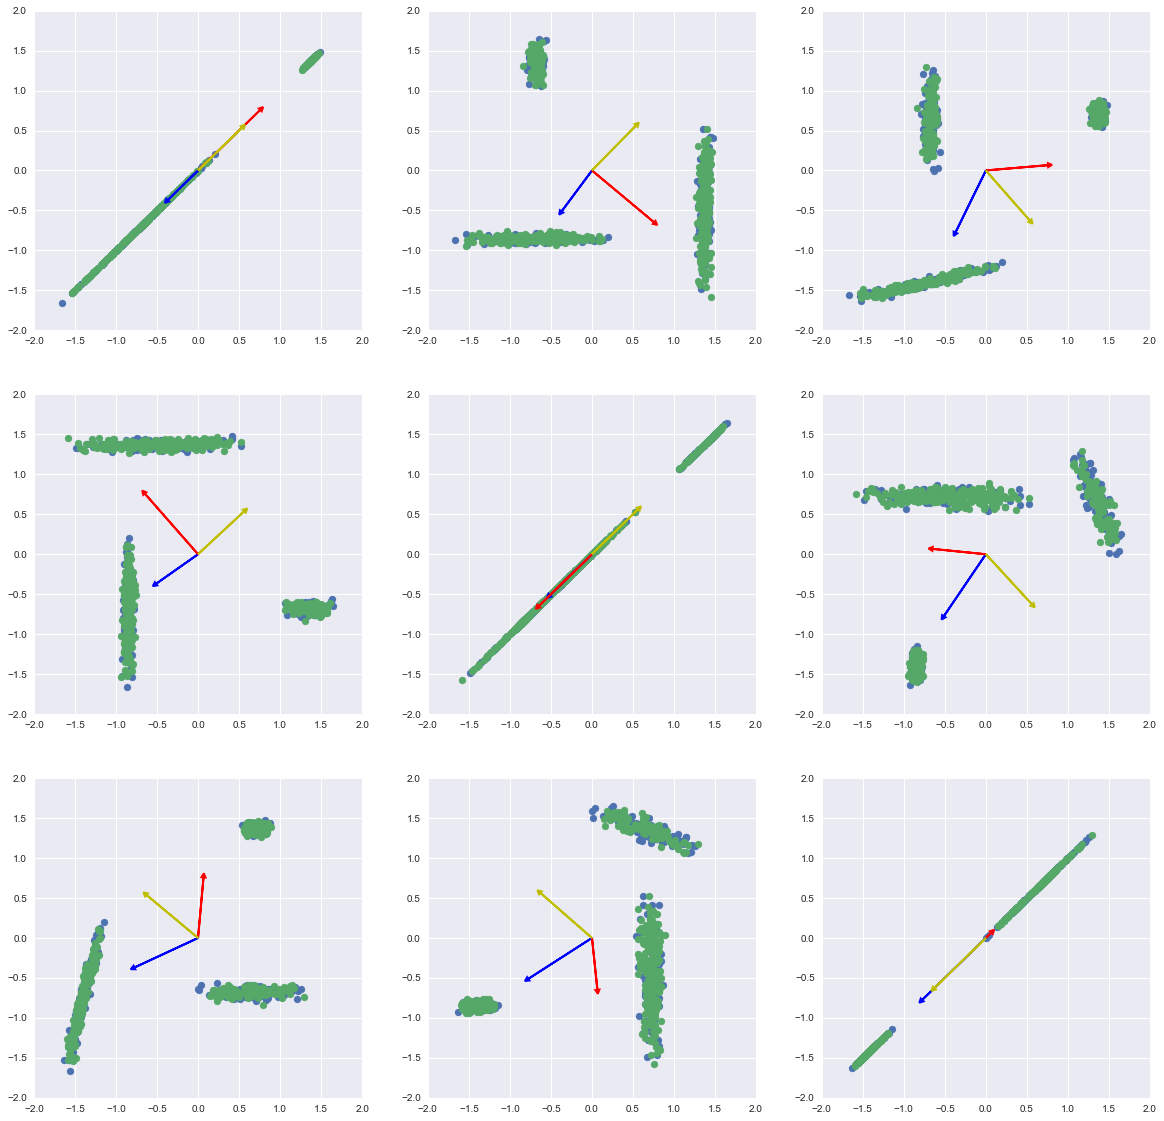

In [527]:
fig, ax = plt.subplots(3,3,figsize = (20,20))

for i in range(3):
    for j in range(3):
        ax[i][j].set_ylim([-2, 2])
        ax[i][j].set_xlim([-2, 2])
        ax[i][j].scatter(X[:,i], X[:, j])
        ax[i][j].scatter(X3[:,i], X3[:, j])
        ax[i][j].arrow(X.mean(axis=0)[i], X.mean(axis=0)[j], comps[0][i]+X.mean(axis=0)[i], comps[0][j]+X.mean(axis=0)[j], lw = 2, head_width=0.05, head_length=0.05, fc='b', ec='b')
        ax[i][j].arrow(X.mean(axis=0)[i], X.mean(axis=0)[j], comps[1][i]+X.mean(axis=0)[i], comps[1][j]+X.mean(axis=0)[j], lw = 2, head_width=0.05, head_length=0.05, fc='b', ec='r')
        ax[i][j].arrow(X.mean(axis=0)[i], X.mean(axis=0)[j], comps[2][i]+X.mean(axis=0)[i], comps[2][j]+X.mean(axis=0)[j], lw = 2, head_width=0.05, head_length=0.05, fc='b', ec='y')

  

In [549]:
from simu_clustering import simu, BasicGenD3

In [532]:
simu(500, 6, 3)

'DictionaryGenerator' object has no attribute 'select_eigvals'


0

In [534]:
pickle.load(open("dg_2017-07-10_19.32.35/res_K6p3N500_c3c06e04-afe2-47c8-b901-20aacdc9d214"))

{'EM_KL': 10.021536404904476,
 'EM_l2': 44.435724795831625,
 'EM_time': 0.5151560306549072,
 'K': 6,
 'KdeCV_KL': 6.6558669810390674,
 'KdeCV_l2': 43.702852892739372,
 'KdeCV_time': 0.8215138912200928,
 'MLE_KL': 5.349419429500144,
 'MLE_l2': 43.37626520714457,
 'MLE_time': 1.3748130798339844,
 'N': 500,
 'p': 3}

In [551]:
bg = BasicGenD3(3)

In [553]:
bg.sample(1000, with_ids=True)

array([[ 0.2932673 ,  0.10202276,  0.16532735,  1.        ],
       [ 0.10318167,  0.8948424 ,  0.61788842,  2.        ],
       [ 0.61037873,  0.20818648,  0.81358805,  3.        ],
       ..., 
       [ 0.22483647,  0.10564201,  0.12174231,  1.        ],
       [ 0.28565383,  0.10714764,  0.1604086 ,  1.        ],
       [ 0.60567726, -0.01916299,  0.8211875 ,  3.        ]])

In [547]:
np.random.shuffle(X)

In [548]:
X

array([[  9.66867758e-01,   4.77444834e-01,   1.99230009e-01,
          3.98461417e-01,   3.98189246e-01],
       [  8.02297813e-01,   7.79959273e-01,   8.01444784e-01,
          8.01225200e-01,   8.02420718e-01],
       [ -1.30692484e-03,   9.86866851e-02,   9.64591551e-02,
          1.46815429e-01,   2.56763631e-01],
       [  1.80390700e-01,   3.76511894e-01,   6.55641558e-01,
          8.03504399e-01,   1.00803025e-01],
       [  7.99252817e-01,   7.58150246e-01,   8.05768444e-01,
          8.07644503e-01,   7.69480445e-01],
       [  6.57917340e-01,   2.21090369e-01,   8.94489214e-01,
          8.91868857e-01,   8.81033364e-01],
       [  9.60253783e-01,   3.74048128e-01,   2.02331589e-01,
          4.00882715e-01,   3.99956769e-01],
       [  7.96948154e-01,   8.51353766e-01,   7.95410284e-01,
          8.06419091e-01,   7.77129375e-01],
       [  8.03312605e-01,   8.02263319e-01,   7.98393371e-01,
          8.04922026e-01,   8.50675250e-01],
       [  1.38252890e-01,   3.4441081